In [1]:
# import cv2
!free -h
!nvidia-smi

              total        used        free      shared  buff/cache   available
Mem:          1.0Ti        47Gi        93Gi       129Mi       866Gi       955Gi
Swap:            0B          0B          0B
Wed Jun 28 02:05:32 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.105.01   Driver Version: 515.105.01   CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  On   | 00000000:47:00.0 Off |                    0 |
| N/A   32C    P0    57W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |           

In [3]:
%matplotlib inline
import os
import ants
import SimpleITK as sitk
import tensorflow as tf
from clci_net import CLCI_Net
from keras.optimizers import Adam
import keras.backend as K
from helpers import *

print(f'AntsPy version = {ants.__version__}')
print(f'SimpleITK version = {sitk.__version__}')

AntsPy version = 0.3.8
SimpleITK version = 2.2.0


## Lacunar and MCA IDS

In [4]:
LACUNAR_IDS = [
  'c0001s0004t01',
  'c0001s0005t01',
  'c0002s0001t01',
  'c0002s0002t01',
  'c0002s0003t01',
  'c0002s0004t01',
  'c0002s0005t01',
  'c0002s0008t01',
  'c0002s0014t01',
  'c0002s0022t01',
  'c0002s0024t01',#
  'c0003s0001t01',
  'c0003s0002t01',
  'c0003s0003t01',
  'c0003s0004t01',
  'c0003s0005t01',
  'c0003s0006t01',
  'c0003s0007t01',
  'c0003s0008t01',
  'c0003s0009t01',
  'c0003s0010t01',
  'c0003s0011t01',
  'c0003s0012t01',
  'c0003s0013t01',
  'c0003s0014t01',
  'c0003s0015t01',
  'c0003s0016t01',
  'c0003s0017t01',
  'c0003s0018t01',
  'c0003s0019t01',
  'c0003s0020t01',
  'c0003s0021t01',
  'c0003s0022t01',
  'c0003s0023t01',
  'c0003s0024t01',
  'c0003s0025t01',
  'c0003s0026t01',
  'c0003s0027t01',
  'c0003s0028t01',
  'c0003s0029t01',
  'c0003s0031t01',
  'c0003s0032t01',
  'c0003s0033t01',
  'c0003s0034t01',
  'c0003s0035t01',
  'c0003s0036t01',
  'c0003s0037t01',
  'c0003s0038t01',
  'c0003s0039t01',
  'c0003s0040t01',
  'c0003s0041t01',
  'c0003s0042t01',
  'c0003s0043t01',
  'c0003s0044t01',
  'c0003s0045t01',
  'c0003s0048t01',
  'c0003s0049t01',
  'c0003s0050t01',
  'c0003s0051t01',
  'c0003s0052t01',
  'c0003s0053t01',
  'c0003s0054t01',
  'c0003s0055t01',
  'c0003s0056t01',
  'c0004s0003t01',
  'c0004s0005t01',
  'c0004s0007t01',
  'c0004s0012t01',
  'c0004s0014t01',
  'c0004s0015t01',
  'c0004s0016t01',
  'c0004s0018t01',
  'c0004s0021t01',
  'c0004s0022t01',
  'c0004s0024t01',
  'c0004s0025t01',
  'c0004s0026t01',
  'c0004s0027t01',
  'c0004s0029t01',
  'c0004s0030t01',
  'c0004s0032t01',
  'c0004s0034t01',
  'c0005s0006t01',
  'c0005s0008t01',
  'c0005s0010t01',
  'c0005s0014t01',
  'c0005s0018t01',
  'c0005s0026t01',
  'c0005s0027t01',
  'c0005s0029t01',
  'c0005s0035t01',
  'c0005s0042t01',
  'c0005s0043t01',
  'c0005s0044t01',
  'c0005s0049t01',
  'c0006s0001t01',
  'c0006s0004t01',
  'c0006s0005t01',
  'c0006s0010t01',
  'c0006s0014t01',
  'c0006s0019t01',
  'c0006s0020t01',
  'c0007s0004t01',
  'c0007s0008t01',
  'c0007s0010t01',
  'c0007s0012t01',
  'c0007s0013t01',
  'c0007s0014t01',
  'c0007s0015t01',
  'c0007s0016t01',
  'c0007s0017t01',
  'c0007s0020t01',
  'c0007s0024t01',
  'c0007s0025t01',
  'c0007s0026t01',
  'c0007s0028t01',
  'c0007s0030t01',
  'c0007s0031t01',
  'c0007s0035t01',
  'c0007s0036t01',
  'c0008s0002t01',
  'c0008s0013t01',
  'c0008s0032t01',
  'c0009s0001t01',
  'c0009s0003t01',
  'c0009s0004t01',
  'c0010s0002t01',
  'c0010s0002t02',
  'c0010s0003t01',
  'c0010s0003t02',
  'c0010s0006t01',
  'c0010s0008t01',
  'c0010s0013t01',
  'c0010s0013t02',
  'c0010s0014t01',
  'c0010s0025t01',
  'c0010s0025t02',
  'c0010s0029t01',
  'c0010s0031t01',
  'c0010s0034t01',
  'c0010s0044t01',
  'c0010s0044t02',
  'c0010s0046t01',
  'c0011s0002t01',
  'c0011s0006t01',
  'c0011s0007t01',
  'c0011s0011t01',
  'c0011s0014t01',
  'c0011s0015t01',
]
MCA_IDS = [
  'c0001s0006t01',
  'c0001s0007t01',
  'c0001s0008t01',
  'c0002s0007t01',
  'c0002s0009t01',
  'c0002s0011t01',  
  'c0002s0012t01',
  'c0002s0013t01',
  'c0002s0015t01',
  'c0002s0018t01',
  'c0002s0019t01',
  'c0002s0020t01',
  'c0002s0021t01',
  'c0002s0025t01',  
  'c0003s0030t01',#
  'c0004s0001t01',
  'c0004s0002t01',
  'c0004s0009t01',
  'c0004s0010t01',
  'c0004s0011t01',
  'c0004s0013t01',
  'c0004s0019t01',
  'c0004s0020t01',
  'c0004s0031t01',
  'c0004s0033t01',
  'c0005s0003t01',
  'c0005s0007t01',
  'c0005s0009t01',
  'c0005s0013t01',
  'c0005s0017t01',
  'c0005s0021t01',
  'c0005s0024t01',
  'c0005s0030t01',
  'c0005s0036t01',
  'c0006s0007t01',
  'c0006s0008t01',
  'c0007s0001t01',
  'c0007s0002t01',
  'c0007s0003t01',
  'c0007s0005t01',
  'c0007s0006t01',
  'c0007s0007t01',
  'c0007s0018t01',
  'c0007s0019t01',
  'c0007s0021t01',
  'c0007s0023t01',
  'c0007s0027t01',
  'c0007s0029t01',
  'c0007s0032t01',
  'c0007s0033t01',
  'c0007s0034t01',
  'c0008s0001t01',
  'c0008s0003t01',
  'c0008s0006t01',
  'c0008s0007t01',
  'c0008s0008t01',
  'c0008s0009t01',
  'c0008s0010t01',
  'c0008s0011t01',
  'c0008s0012t01',
  'c0008s0014t01',
  'c0008s0015t01',
  'c0008s0016t01',
  'c0008s0017t01',
  'c0008s0018t01',
  'c0008s0019t01',
  'c0008s0020t01',
  'c0008s0021t01',
  'c0008s0022t01',
  'c0008s0023t01',
  'c0008s0024t01',
  'c0008s0025t01',
  'c0008s0026t01',
  'c0008s0027t01',
  'c0008s0028t01',
  'c0008s0029t01',
  'c0008s0030t01',
  'c0008s0031t01',
  'c0008s0033t01',
  'c0009s0002t01',
  'c0009s0005t01',
  'c0009s0006t01',
  'c0009s0007t01',
  'c0009s0008t01',
  'c0009s0009t01',
  'c0009s0010t01',
  'c0009s0011t01',
  'c0009s0012t01',
  'c0010s0001t01',
  'c0010s0004t01',
  'c0010s0005t01',
  'c0010s0005t02',
  'c0010s0007t01',
  'c0010s0018t01',
  'c0010s0020t01',
  'c0010s0020t02',
  'c0010s0021t01',
  'c0010s0024t01',
  'c0010s0032t01',
  'c0010s0037t01',
  'c0011s0001t01',
  'c0011s0003t01',
  'c0011s0004t01',
  'c0011s0005t01',
  'c0011s0008t01',
  'c0011s0009t01',
  'c0011s0012t01',
  'c0011s0013t01'
]

In [5]:
len(LACUNAR_IDS) + len(MCA_IDS)

257

In [6]:
base_path = '/home/carlos.jimenez/ai-in-health/Stroke-Brain-Lesions'
datasets_path = f'{base_path}/datasets/paper lesions extended'
models_path = f'{base_path}/modelos/paper lesions extended'
mni_T1_path = TEMPLATE_PATH = f'{base_path}/datasets/templates/mni_icbm152_t1_tal_nlin_sym_09a.nii'

# strategy = tf.distribute.MirroredStrategy()

## Check images belonging to classes !!

In [7]:
def id_from_path(path:str) -> str:
  """
    Extracts the ID from the given file path.

    Args:
        path (str): The file path from which to extract the ID.

    Returns:
        str: The extracted ID from the file path.
    """

  #may need to be updated if data location change
  return path.split('/')[-1]


In [8]:
def id_from_mask_path(path:str) -> str:
  """
    Extracts the ID from the given mask file path.

    Args:
        path (str): The file path from which to extract the ID.

    Returns:
        str: The extracted ID from the mask file path.
    """
  #may need to be updated if data location change
  return path.split('/')[-1].split('_')[0]

In [ ]:
from glob import glob
folders =  sorted(glob(f'{datasets_path}/NATIVE/*/*'))
len([x for x in folders if 'Raw' not in x or '_1.nii.gz' not in x])
folders[:4]
# print(folders[:3])

In [10]:
#just MCA and lacunar
whole = MCA_IDS + LACUNAR_IDS
folders_filtered = [ f 
                    for f in folders 
                    if id_from_path(f) in whole]
print(len(folders_filtered))
filtered_ids = [id_from_path(p) for p in folders_filtered]


257


In [11]:
all_paths = sorted(glob(f'{datasets_path}/NATIVE/*/*/*.nii.gz') )

xpaths = [x for x in all_paths if 'LesionSmooth' not in x]
ypaths = [x for x in all_paths if 'LesionSmooth.nii.gz' in x]
IDS = list([path.split('/')[-2] for path in xpaths])
# len(IDS)
len(xpaths), len(ypaths)

# xpaths[:100]
# set(xpaths) - set(ypaths)
# xpaths[:10], ypaths[:10]
# masked = sorted(glob(f'{datasets_path}/native_processed_masked/*'))
# masked_ids = [id_from_path(p)[:-24] for p in masked]
# len(masked_ids)

(305, 304)

In [12]:
# missing = [p for p in filtered_ids if p not in masked_ids]
# missing

In [13]:
# for i, f in enumerate(folders_filtered):
#   xpath = f+'/'+id_from_path(f)+'.nii.gz'
#   ypath = f+'/'+id_from_path(f)+'_LesionSmooth.nii.gz'
#   print(xpath)
#   print(ypath)
#   if i == 3 : break
# folders_filtered

## Preprocessing steps functions

In [14]:
mni_T1_path = TEMPLATE_PATH = f'{base_path}/datasets/templates/mni_icbm152_t1_tal_nlin_sym_09a.nii'

def load_template_ants() -> ants.ANTsImage:
    """
    Loads the template image using the ANTs library.

    Returns:
        ants.ANTsImage: The loaded template image as an ANTsImage object.
    """
    template_img_ants = ants.image_read(TEMPLATE_PATH)
    return template_img_ants

def load_img_ants(path: str) -> ants.ANTsImage:
    """
    Loads an image from the specified file path using the ANTs library.

    Args:
        path (str): The file path of the image to be loaded.

    Returns:
        ants.ANTsImage: The loaded image as an ANTsImage object.
    """
    raw_img_ants = ants.image_read(path)
    return raw_img_ants

def register_to_mni(img: ants.ANTsImage, mask: ants.ANTsImage) -> ants.ANTsImage:
    """
    Registers an MRI image and its associated mask to the MNI space using ANTs library.

    Args:
        img (ants.ANTsImage): The MRI image to be registered.
        mask (ants.ANTsImage): The mask associated with the MRI image.

    Returns:
        ants.ANTsImage: The registered MRI image in MNI space.
        ants.ANTsImage: The registered mask in MNI space.
    """
    template_img = load_template_ants()
    transformation = ants.registration(fixed=template_img, moving=img, type_of_transform='SyN')

    img_registered = transformation['warpedmovout']
  
    mask_registered = ants.apply_transforms(fixed=template_img,moving=mask,transformlist=transformation['fwdtransforms'])
    return img_registered, mask_registered

def register_to_mni_single(img: ants.ANTsImage) -> ants.ANTsImage:
    """
    Register an ANTs MRI image to the MNI (Montreal Neurological Institute) space.

    Args:
        img (ants.ANTsImage): The ANTs MRI image to be registered.

    Returns:
        ants.ANTsImage: The registered MRI image in the MNI space.
    """
    template_img = load_template_ants()
    transformation = ants.registration(fixed=template_img, moving=img, type_of_transform='SyN')

    img_registered = transformation['warpedmovout']
  
    return img_registered

In [15]:
def bias_field_correction(img: sitk.Image) -> sitk.Image:
    """
    Perform bias field correction on the input image using N4BiasFieldCorrection.

    Args:
        img (sitk.Image): The input image to be bias corrected.

    Returns:
        sitk.Image: The bias-corrected image.
    """
    head_mask = sitk.RescaleIntensity(img, 0, 255)
    head_mask = sitk.LiThreshold(head_mask,0,1)
    # Shrinking the input image and head mask for faster processing
    shrinkFactor = 4
    inputImage = img
    inputImage = sitk.Shrink( img, [ shrinkFactor ] * inputImage.GetDimension() )
    maskImage = sitk.Shrink( head_mask, [ shrinkFactor ] * inputImage.GetDimension() )

    bias_corrector = sitk.N4BiasFieldCorrectionImageFilter()
    bias_corrector.Execute(inputImage, maskImage)

    log_bias_field = bias_corrector.GetLogBiasFieldAsImage(img)
    result = img / sitk.Exp( log_bias_field ) # corrected img at full resolution

    # output of division has 64 pixel type, we cast it to float32 to keep compatibility
    result = sitk.Cast(result, sitk.sitkFloat32)
    
    return result

def load_img_sitk(path: str) -> sitk.Image:
    raw_img_sitk = sitk.ReadImage(path, sitk.sitkFloat32)
    return raw_img_sitk

In [16]:
# load mni152 brain mask
TEMPLATE_BRAIN_MASK_PATH = f'{base_path}/datasets/templates/mni_icbm152_t1_tal_nlin_sym_09a_mask.nii'
mni152_brain_mask = sitk.ReadImage(TEMPLATE_BRAIN_MASK_PATH, sitk.sitkFloat32)
mni152_T1 = sitk.ReadImage(TEMPLATE_PATH, sitk.sitkFloat32)

print(load_img_ants(TEMPLATE_PATH).numpy().shape)
print(sitk.GetArrayFromImage(load_img_sitk(TEMPLATE_PATH)).shape)
# masked = load_img_sitk('/home/carlos.jimenez/ai-in-health/Stroke-Brain-Lesions/datasets/paper lesions extended/native_processed_masked/c0001s0004t01_processed_masked.nii.gz')

(197, 233, 189)
(189, 233, 197)


In [17]:
# np_masked = sitk.GetArrayFromImage(masked)
# explore_3D_array(np_masked)


In [18]:
import numpy as np
from typing import Tuple
def preprocess_ximg(ximg: sitk.Image, flipped = False) -> Tuple[np.ndarray, sitk.Image]:
  """
    Preprocesses an input SimpleITK image.

    Args:
        ximg (sitk.Image): The input SimpleITK image to be preprocessed.
        flipped (bool, optional): If True, the image will be flipped along the y-axis.
                                  Defaults to False.

    Returns:
        Tuple[np.ndarray, sitk.Image]: A tuple containing the preprocessed numpy array (x3d) and the
                                       preprocessed SimpleITK image (x3d_sitk_preprocessed).
    """
  x3d = sitk.HistogramMatching(ximg, mni152_T1)
  x3d = sitk.Multiply(x3d, mni152_brain_mask) # mask brain
  x3d = sitk.CurvatureAnisotropicDiffusion(x3d, conductanceParameter=1, numberOfIterations=1) # denoise a bit
  x3d_sitk_preprocessed = x3d
  
  if flipped:
    x3d = sitk.Flip(x3d,(True, False, False))
  
  x3d = sitk.GetArrayFromImage(x3d)
  x3d = x3d[30:160,4:228,14:190] # crop to size -> (130, 224, 176)
  x3d = x3d / 255.0
  x3d = np.expand_dims(x3d,3) # add channel -> (130, 224, 176, 1)
  assert x3d.shape == (130,224,176,1)
  return x3d, x3d_sitk_preprocessed

def preprocess_yimg(yimg: sitk.Image, flipped=False) -> np.ndarray:
  """
    Preprocesses an input SimpleITK image representing the labels (y-values).

    Args:
        yimg (sitk.Image): The input SimpleITK image representing the labels to be preprocessed.
        flipped (bool, optional): If True, the image will be flipped along the y-axis.
                                  Defaults to False.

    Returns:
        np.ndarray: The preprocessed numpy array representing the labels (y3d).
    """
  y3d = yimg

  if flipped:
    y3d = sitk.Flip(y3d,(True, False, False))
  
  y3d = sitk.GetArrayFromImage(y3d)
  y3d = y3d[30:160,4:228,14:190] # crop to size -> (130, 224, 176)
  y3d = y3d / 255.0
  y3d = np.expand_dims(y3d,3) # add channel -> (130, 224, 176, 1)
  assert x3d.shape == (130,224,176,1)
  return y3d


In [19]:
def postprocess_pred(
    raw_pred: np.ndarray,
    ximg_ref_path: str
  ) -> sitk.Image:
  """
  creates a mri image mask from the prediction, padding is used to fit the dimensions
  of an image standardized with mni152 template
  
  ximg_ref_path: is the path of the mri image to get metadata as reference
  """
  assert raw_pred.shape  == (130,224,176,1)
  
  pred = raw_pred.copy()
  pred = pred > 0.5
  pred = pred[:,:,:,0]*255.0
  pred = np.pad(pred, ((29,30), (3,6), (13, 8)))
  assert pred.shape == (189,233,197)

  output = sitk.GetImageFromArray(pred)    
  output.CopyInformation(sitk.ReadImage(ximg_ref_path, sitk.sitkFloat32))
  return output

## Load model and weights

In [20]:
model = CLCI_Net()
# model_path = f"{models_path}/clcinet-native-ALL-DOUBLED-v6.h5"
model_path = f"{models_path}/clcinet-native-ALL-DOUBLED-v1-fifth-training-045-0.892773-0.800735.h5"
model.load_weights(model_path)

2023-06-28 02:06:13.015865: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-28 02:06:14.937132: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38266 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:47:00.0, compute capability: 8.0
2023-06-28 02:06:14.938481: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38266 MB memory:  -> device: 1, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:4e:00.0, compute capability: 8.0
2023-06-28 02:06:14.939681: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/devi

In [21]:
from numpy import load
X_input_path = f'{datasets_path}/dataset_clinet_input_processed_ALL_DOUBLED_X.npy'
Y_input_path = f'{datasets_path}/dataset_clinet_input_processed_ALL_DOUBLED_Y.npy'

X = load(X_input_path)
Y = load(Y_input_path)
X.shape, Y.shape

((75920, 224, 176, 1), (75920, 224, 176, 1))

## !! Register + BF + preprocess + predict +  mask + save

In [22]:
# ants.from_numpy(X[:130].reshape())
# X[:130].shape

In [23]:
# import random
# from pprint import pprint
# random.seed(127)
# sample = random.sample(folders_filtered,5)
# pprint(sample)

In [24]:
# load
# !free -h

In [25]:
os.listdir(f'{base_path}/datasets/native_registered')[:4]

['c0001s0004t01_registered.nii.gz',
 'c0001s0005t01_registered.nii.gz',
 'c0001s0006t01_registered.nii.gz',
 'c0001s0007t01_registered.nii.gz']

In [27]:
# os.listdir(path_to_save)[:4]

In [ ]:
path_to_save = f"{datasets_path}/native_processed_masked_best"
registered = os.listdir(f'{base_path}/datasets/native_registered')
masks = os.listdir(path_to_save)

print(len(folders_filtered))
missing = ['c0010s0002t02',
 'c0010s0003t02',
 'c0010s0005t02',
 'c0010s0013t02',
 'c0010s0020t02',
 'c0010s0025t02',
 'c0010s0044t02']
for i,xpath in enumerate(folders_filtered):
    
    file_name = xpath.split('/')[-1]
    # Check if the processed and masked image for the current file is not already present
    if f'{file_name}_processed_masked.nii.gz' not in masks:

        # Load the original image (x3d) from the folder path
        nii_path = f'{xpath}/{file_name}.nii.gz'
        x3d = load_img_ants(nii_path)

        #y3d = load_img_ants(ypath)

        x3d_registered_path = f'{base_path}/datasets/native_registered/{file_name}_registered.nii.gz'
        #y_registered_path = f'{base_path}/datasets/native_registered/{file_name[:-7]}_registered.nii.gz'
        #x3d_registered, y3d_registered = register_to_mni(img=x3d,mask=y3d)
        x3d_registered = register_to_mni_single(img=x3d)

        if f'{file_name}_registered.nii.gz' not in registered:
            x3d_registered.to_file(x3d_registered_path)
    #     y3d_registered.to_file(y_registered_path)


        # Perform bias field correction on the registered image
        x3d = load_img_sitk(x3d_registered_path)
        x3d_bf_corrected = bias_field_correction(x3d)

        # Preprocess the bias field corrected image (x3d)
        ximg = x3d_bf_corrected
        x3d, x3d_sitk_preprocessed = preprocess_ximg(ximg)

        # Generate a mask for the preprocessed image using the trained model
#         x3d = X[i*130:(i+1)*130]
        raw_pred = model.predict(x3d,batch_size=1,verbose=1)
        mask = postprocess_pred(raw_pred, TEMPLATE_PATH)

        # Normalize the mask values to [0, 1] range and convert it to float32 type
        mask = sitk.Divide(mask, 255.0) # because mask comes with values in {255,0}
        mask = sitk.Cast(mask, sitk.sitkFloat32) # for some reason mask comes with float type 64 bit
        masked = sitk.Multiply(x3d_sitk_preprocessed, mask)

        # Write the masked image to the specified output path
        out_path = f'{path_to_save}/{file_name}_processed_masked.nii.gz'
        sitk.WriteImage(masked, out_path)

        print(i+1,file_name)
#         if i == 0 : break

## Inspect masks generated

### Load images


In [ ]:
mpaths = sorted(glob(f'/data/NATIVE/*/*/*01_maskGenerated.nii.gz'))

In [ ]:
print("Number of samples:", len(mpaths))
for input_path in mpaths:
    print(input_path[-35:])

In [ ]:
# explore masked
i = 0
# Get the file path of the example image (test image), based on the given example folder path
example = sample[i]

test_xpath = example+'/'+id_from_path(example)+'_registered.nii.gz'
test_ypath = example+'/'+id_from_path(example)+'_LesionSmooth_registered.nii.gz'

test_mask =  example+'/'+id_from_path(example)+'_maskGenerated.nii.gz'
# Read the test images and the mask using SimpleITK's ReadImage function
test_ximg = sitk.ReadImage(test_xpath, sitk.sitkFloat32)
test_yimg = sitk.ReadImage(test_ypath, sitk.sitkFloat32)
test_mask = sitk.ReadImage(test_mask, sitk.sitkFloat32)

test_mask = sitk.Divide(test_mask, 255.0) # because mask comes with values in {255,0}
masked = sitk.Multiply(test_ximg, test_mask)

explore_3D_array(sitk.GetArrayFromImage(masked))

In [ ]:
# compare mask
i = 0
example = sample[i]

test_xpath = example+'/'+id_from_path(example)+'.nii.gz'
test_ypath = example+'/'+id_from_path(example)+'_LesionSmooth_registered.nii.gz'

test_mask =  example+'/'+id_from_path(example)+'_maskGenerated.nii.gz'

test_img = sitk.ReadImage(test_ypath, sitk.sitkFloat32)
test_mask = sitk.ReadImage(test_mask, sitk.sitkFloat32)
# Compare and visualize the two 3D image volumes using the custom function 'explore_3D_array_comparison'
explore_3D_array_comparison(
    arr_before=sitk.GetArrayFromImage(test_img),
    arr_after=sitk.GetArrayFromImage(test_mask),
    #cmap='viridis'
)

## See how to Persist processed and masked images

In [ ]:
mpaths = sorted(glob(f'/data/NATIVE/*/*/*01_processed_masked.nii.gz') )

print("Number of samples:", len(mpaths))
for input_path in mpaths:
    print(input_path[-35:])


In [6]:
# masked_path
from helpers import *

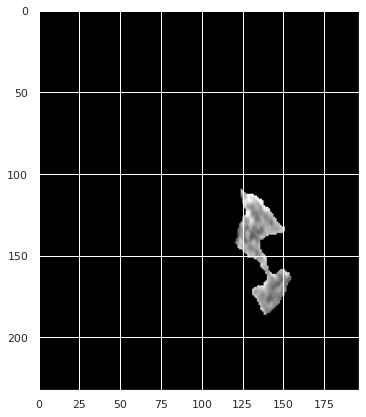

In [16]:
mpaths = f"{datasets_path}/native_processed_masked_best"
# Loop through the first 5 image files in the 'native_processed_masked_best' directory
for i, input_path in enumerate(os.listdir(mpaths)):
    path = f'{mpaths}/{input_path}'
    # Read the image file using SimpleITK and convert it to a 3D SimpleITK image
    img = sitk.ReadImage(path, sitk.sitkFloat32)
    explore_3D_array(sitk.GetArrayFromImage(img))
    # Stop the loop after processing the first 5 images
    if i == 4: break
    

